# 0. Download data and setup environment.

The environment used to run this problem set should have already been setup for you. Likewise, the data used for the problem set should already have been downloaded.


### Setup environment
To check that your environment is correctly setup, do the following.

1. Check that the kernel is correctly set to `Python (ps1)`. If not, switch the kernel to `Python (ps1)`. You can do so by clicking on the button to the right of the debugger (bug symbol) button.
2. Execute the following function.

In [28]:
def check_key_installations ():
    # Check if pandas, gensim, spacy and pyphen are installed
    try:
        import pandas as pd
        import pyphen
        dic = pyphen.Pyphen(lang='fr_FR')
        assert dic.inserted('fromage') == 'fro-mage'
        import scipy
        assert scipy.__version__ == '1.12.0'
        import gensim.downloader
        import spacy
        nlp = spacy.load ("en_core_web_sm", disable=["ner", "parser"])
        nlp.disable_pipe ("ner")
        nlp.disable_pipe ("parser")
        doc = nlp ("Trying to parse this sentence")
        print (doc)
        # Import nltk and download the punct models
        import nltk
        nltk.download ("punkt_tab")
        print ("Environment has been setup!")
    except Exception as e:
        print (e)

check_key_installations ()

In [29]:
import random

In [30]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.


In [31]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 80.2 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


If the function executes and prints "Environment has been setup!", then you are set; otherwise go to the next step.

3. Depending on the error you're facing, you may have to install missing packages by running the following commands.

```
pip install pyphen
pip install scipy==1.12
python -m spacy download en_core_web_sm 
```

If you still encounter any problem and you can't resolve on your own, please send an email to `qtm340-support@listserv.emory.edu` describing your problem and attach a screenshot.

### Download the data

To check if the data for this problem set is already downloaded, perform the following steps.

1. Check if `us_congress_speeches.parquet.gz` and `uk_parl_df.parquet.gz` are already present in your current directory. You can check this by executing the following cell. 

If the two files are not present, then copy the following and execute in a cell, which should download the two parquet files

In [ ]:
!pip install gdown  # Ensure gdown is installed
import gdown

# Define file IDs
us_speeches_id = "1nCZBeSHcBL3dFUcGiKFbArrxm8tO5S5D"
uk_speeches_id = "1XVMU67O21tMm6bh-Dqyr9uj7LSML6Eic"

# Define output file names
us_output = "us_congress_speeches.zip"
uk_output = "uk_parliament_speeches.zip"

# Download files
gdown.download(f"https://drive.google.com/uc?id={us_speeches_id}", us_output, quiet=False)
gdown.download(f"https://drive.google.com/uc?id={uk_speeches_id}", uk_output, quiet=False)

print("Download complete!")


Downloading...
From (original): https://drive.google.com/uc?id=1nCZBeSHcBL3dFUcGiKFbArrxm8tO5S5D
From (redirected): https://drive.google.com/uc?id=1nCZBeSHcBL3dFUcGiKFbArrxm8tO5S5D&confirm=t&uuid=43155810-3935-48b9-a885-debac8edfbf3
To: /Users/lingyizhao/emory/2025 spring/qtm 340/ps1/us_congress_speeches.zip
100%|██████████| 171M/171M [00:02<00:00, 62.4MB/s] 
Downloading...
From (original): https://drive.google.com/uc?id=1XVMU67O21tMm6bh-Dqyr9uj7LSML6Eic
From (redirected): https://drive.google.com/uc?id=1XVMU67O21tMm6bh-Dqyr9uj7LSML6Eic&confirm=t&uuid=cc9b204e-c6ad-4195-a133-1a43242afe03
To: /Users/lingyizhao/emory/2025 spring/qtm 340/ps1/uk_parliament_speeches.zip
100%|██████████| 280M/280M [00:04<00:00, 66.9MB/s] 

Download complete!


```
%%bash
gdown 1nCZBeSHcBL3dFUcGiKFbArrxm8tO5S5D # US congressional speeches data
gdown 1XVMU67O21tMm6bh-Dqyr9uj7LSML6Eic # UK parliament speeches data
```

Parquet files are specially formatted binary files to store dataframes efficiently. `pandas` provides functionality to load and save data from or to compressed parquet files. 

# 1. Initialization

Let's organize. We'll keep all the import statements and configuration of global variables/objects in one cell so it's easy to track.

In [ ]:
# Import the general libraries
import math
import pandas as pd
from tqdm import tqdm
import numpy as np
from collections import defaultdict, Counter
import matplotlib.pyplot as pyplot
%matplotlib inline

# Import spacy and configure the nlp pipeline for spacy
import spacy
nlp = spacy.load ("en_core_web_sm", disable=["ner", "parser"])
nlp.disable_pipe ("ner")
nlp.disable_pipe ("parser")

# Import nltk and download the punct models
import nltk
nltk.download ("punkt_tab")

import pyphen
# Initialize the pyphen objects
dic_us = pyphen.Pyphen (lang="en_US")
dic_uk = pyphen.Pyphen (lang="en_GB")

# Initialize a pre-trained word2vec model
import gensim.downloader
from gensim.models import Word2Vec
w2v_pretrained_model = gensim.downloader.load('glove-wiki-gigaword-100')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/lingyizhao/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


[==================================================] 100.0% 128.1/128.1MB downloaded


Next, we'll load the data into dataframes

In [ ]:
import pandas as pd
#us_speeches = pd.read_parquet("us_congress_speeches.parquet.gz", engine="fastparquet", compression="gzip")

us_speeches = pd.read_parquet ("us_congress_speeches.zip")
uk_speeches = pd.read_parquet ("uk_parliament_speeches.zip")

# Remove all the US congress speeches that are not from a speaker with either a
# democrat or republican affiliation
us_speeches = us_speeches[us_speeches["party"].isin (["R", "D"])]

# Remove all the UK speeches whose gender is None
uk_speeches = uk_speeches[~uk_speeches["gender"].isna()]

In [ ]:
!pip install fastparquet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.1/684.1 kB 9.8 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.6 MB/s eta 0:00:00a 0:00:01


In [ ]:
us_speeches

,speakerid,speech_id,chamber,gender,party,congress,tokenized_speech
0,107113420,1070000102,H,M,R,107,"[mr., clerk., the, congress, and, the, nation,..."
1,107113640,1070000104,H,M,D,107,"[mr., clerk., as, chairman, of, the, democrati..."
2,107113650,1070000110,H,M,D,107,"[members, of, the, house., families, of, house..."
3,107114840,1070000111,H,M,R,107,"[i, guess, i, really, should, not, hammer, it,..."
4,107117580,1070000112,H,M,D,107,"[then, administered, the, oath, of, office, to..."
...,...,...,...,...,...,...,...
331253,111121290,1110111060,H,M,D,111,"[i, would, agree., and, i, have, introduced., ..."
331254,111121290,1110120299,H,M,D,111,"[madam, speaker., i, yield, such, time, as, he..."
331256,111118710,1110120587,H,M,R,111,"[in, his, 5minute, speech., talked, about, the..."
331257,111121510,1110134147,H,M,D,111,"[madam, speaker., i, rise, today, to, honor, m..."


We should have two dataframes now. One that holds the data for US congressional speeches and the other for UK parliamentary speech.

For the **US speeches**, we have the following columns in the dataframe.

- `speakerid`: An ID to distinguish between different speakers (for this assigment, we can ignore this column)
- `speech_id`: An ID to distinguish between different speeches or speech segments (for this assigment, we can ignore this column also)
- `chamber`: The chamber in which this speech was made. As part of preprocessing, only the speeches made in the house were retained.
- `gender`: The binary gender of the speaker. The value is one of {M,F}
- `party`: The party of the speaker. We've ignored any speeches that are not marked as either 'R' or 'D'. 'R' stands for a speech by a member of congress who has identified themselves with the Republican party; 'D' stands for democratic party.
- `congress`: The congress session. The values range from 107 to 111. 107th congress spans roughly from the beginning of 2001 to the end of 2002. Every subsequent corpus is of 2 years. You'll need this type of mapping to do temporal analysis.
- `tokenized_speech`: The speech segmented into tokens. The tokens are obtained by running spacy on the raw text.


For the **UK speeches**, we have the following columns in the dataframe.
- `id`: An ID to distinguish every speech or speech segment.
- `speech_date`: Unlike US speeches, every speech in the UK dataset is marked with a precise date.
- `year`: Year extracted from the date
- `gender`: The gender of the speaker. Values can be one of {"Male", "Female"}
- `party`: The party of the speaker. Since we won't do any comparative analysis of speeches for this dataset, you can ignore the party in your analysis.
- `tokenized_speech`: The speech segmented into tokens. The tokens are obtained by running spacy on the raw text.


In [ ]:
us_speeches

,speakerid,speech_id,chamber,gender,party,congress,tokenized_speech
0,107113420,1070000102,H,M,R,107,"[mr., clerk., the, congress, and, the, nation,..."
1,107113640,1070000104,H,M,D,107,"[mr., clerk., as, chairman, of, the, democrati..."
2,107113650,1070000110,H,M,D,107,"[members, of, the, house., families, of, house..."
3,107114840,1070000111,H,M,R,107,"[i, guess, i, really, should, not, hammer, it,..."
4,107117580,1070000112,H,M,D,107,"[then, administered, the, oath, of, office, to..."
...,...,...,...,...,...,...,...
331253,111121290,1110111060,H,M,D,111,"[i, would, agree., and, i, have, introduced., ..."
331254,111121290,1110120299,H,M,D,111,"[madam, speaker., i, yield, such, time, as, he..."
331256,111118710,1110120587,H,M,R,111,"[in, his, 5minute, speech., talked, about, the..."
331257,111121510,1110134147,H,M,D,111,"[madam, speaker., i, rise, today, to, honor, m..."


In [ ]:
uk_speeches

,id,speech_date,year,gender,party,tokenized_speech
3182,2001-01-15a.3.3,2001-01-15,2001,Male,Independent Conservative,"[is, not, it, noteworthy, that, supporters, of..."
3183,2001-01-15a.7.3,2001-01-15,2001,Male,Labour,"[may, i, take, the, opportunity, to, remove, a..."
3185,2001-01-15a.7.7,2001-01-15,2001,Male,Labour,"[i, can, give, you, that, assurance, absolutel..."
3186,2001-01-15a.15.2,2001-01-15,2001,Male,Independent Conservative,"[yesterday's, sunday, telegraph, reported, tha..."
3187,2001-01-15a.26.0,2001-01-15,2001,Male,Independent Conservative,"[in, a, disaster, of, such, magnitude,, is, no..."
...,...,...,...,...,...,...
808784,2010-12-14a.871.0,2010-12-14,2010,Male,Labour,"[i, think, i, will, take, that, as, a, sort, o..."
808785,2010-12-14a.872.0,2010-12-14,2010,Male,Conservative,"[i, beg, to, move,, that, the, bill, be, now, ..."
808787,2010-12-14a.874.0,2010-12-14,2010,Male,Labour,"[i, simply, want, to, say, on, behalf, of, the..."
808788,2010-12-14a.874.1,2010-12-14,2010,Male,Liberal Democrat,"[i, have, spoken, on, a, number, of, issues, a..."


In [ ]:
us_speeches.head (3)

,speakerid,speech_id,chamber,gender,party,congress,tokenized_speech
0,107113420,1070000102,H,M,R,107,"[mr., clerk., the, congress, and, the, nation,..."
1,107113640,1070000104,H,M,D,107,"[mr., clerk., as, chairman, of, the, democrati..."
2,107113650,1070000110,H,M,D,107,"[members, of, the, house., families, of, house..."


In [ ]:
uk_speeches.head (3)

,id,speech_date,year,gender,party,tokenized_speech
3182,2001-01-15a.3.3,2001-01-15,2001,Male,Independent Conservative,"[is, not, it, noteworthy, that, supporters, of..."
3183,2001-01-15a.7.3,2001-01-15,2001,Male,Labour,"[may, i, take, the, opportunity, to, remove, a..."
3185,2001-01-15a.7.7,2001-01-15,2001,Male,Labour,"[i, can, give, you, that, assurance, absolutel..."


# 2. Stylistic Variation

Let's implement the `meanWordChars` metric, which is supposed to calculate the average length of a word in the corpus. Following is a simple, self-explanatory function to calculate the average length of a token in a given corpus. I'm using the cell magic `timeit` to log the execution time.

In [33]:
%%timeit -n 1 -r 3
def slowest_meanWordChars (speeches):
  """ Function calculates the average number of characters per word.

  This is the most basic and inefficient implementation of meanWordChars,
  since it is using two for loops and not vectorization.

  params
  :speeches: iterable

  returns
  :avg_chars: float
  """
  num_chars = 0
  num_words = 0
  for speech in speeches['tokenized_speech']:
    for token in speech:
      num_chars += len(token)
      num_words += 1
  return num_chars / num_words

# Basic implementation of meanWordChars
print (slowest_meanWordChars (us_speeches))

4.808280087616606
4.808280087616606
4.808280087616606
9.07 s ± 2.73 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


The above code takes approximately 2.6secs to calculate this metric on the full US speeches corpus. Not great! 😌 

Though this code is easy to write, we can't afford slow computation on one metric because:

- (a) we'll recalculate the metric repeatedly in bootstrapped samples
- (b) there are other metrics we want to calculate as well.

The slow runtime of this function is because of the use of for loops which don't leverage [vectorization](https://pythonspeed.com/articles/pandas-vectorization/). See the following function to understand what I mean. I use the `pandas.apply` function to instruct pandas to repeat an operation on each row. Please see the code explanation in the comments within the function.

In [ ]:
%%timeit -n 1 -r 3
def slow_meanWordChars (speeches):
  """ Function calculates the average number of characters per word.

  This is the second most inefficient implementation of meanWordChars.
  It's using vectorization but still computing everything from the
  tokenized_speech column.

  params
  :speeches: iterable

  returns
  :avg_chars: float
  """
  # Code Explanation:
  #   `speeches['tokenized_speech'].apply (lambda x: len (''.join(x)))`
  #    creates a vector of character counts for every speech
  #   `speeches['tokenized_speech'].apply (lambda x: len (x)).sum()`
  #    creates a vector of token counts for every speech
  #    `.sum()` gets the sum of all values in a the vector
  #    `/` operator does elementwise division of two vectors

  avg_chars = speeches['tokenized_speech'].apply (lambda x: len (''.join(x))).sum() / speeches['tokenized_speech'].apply (lambda x: len (x)).sum()
  return avg_chars

# Vectorized implementation of meanWordChars
print (slow_meanWordChars (us_speeches))

4.808280087616606
4.808280087616606
4.808280087616606
1.7 s ± 3.16 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Nice! 👍  

Our code executes in 1.6 seconds i.e. we have cut the runtime by one third and we still produce the same answer. 

Can we do even better?

Yes! We can. Further improvement in time will, however, come at a cost. 

The key observation is that the above function ends up repeating the computation for tokens that it has already seen before. But if we know all the words that ever appear in the corpus, then we can calculate their lengths in one go and store them for further retrieval. More specifically, we'll start by writing a function to construct a vocabulary from a given corpus. 

Vocabulary is going to be a python dictionary. Key in the vocabulary is going to be a word and the corresponding value is the number of times the word appears in the input corpus.

In [ ]:
def construct_vocab (df):
  """ Function constructs a vocabulary from the tokenized speech column of the dataframe

  params
  :df (pd.DataFrame): dataframe with a tokenized_speech column

  returns
  :vocab (dict): keys are the word types and values are the number of times they
          appear in the corpus
  """

  vocab = dict ()
  for speech in df['tokenized_speech']:
    for token in speech:
      if token in vocab:
        vocab[token] += 1
      else:
        vocab[token] = 1
  return vocab

Next, we will also write functions to create dictionaries to track character counts and syllable counts. We can then use lookup operation to retrieve the length of a word in terms of characters or syllables using the appropriate dictionaries.

In [ ]:
def construct_char_count (vocab):
  """ Function constructs a dictionary mapping every word to its character count
  in the corpus

  params
  :vocab (dict): keys are the word types and values are the number of times they
          appear in the corpus

  returns
  :char_count (dict): keys are the word types and values are the number of
          characters in the word
  """
  char_count = dict ()
  for word in vocab:
    char_count[word] = len(word)
  return char_count

def construct_syllable_count (vocab, syllable_counter):
  """ Function constructs a dictionary mapping every word to its syllable count
  in the corpus

  params
  :vocab (dict): keys are the word types and values are the number of times they
          appear in the corpus
  :syllable_counter (pyphen.Pyphen): syllable counter object

  returns
  :syllables_count (dict): keys are the word types and values are the number of
          syllables in the word
  """
  syllables_count = dict ()
  for word in vocab:
    syllables_count[word] = len(syllable_counter.inserted(word).split('-'))
  return syllables_count

Finally, using the above functions, we can **precompute** the word lengths for every speech in a corpus as below.

In [ ]:
# Construct the vocabulary for the two corpora
us_vocab = construct_vocab (us_speeches)
uk_vocab = construct_vocab (uk_speeches)

# Keep the mappings of word to character count
us_char_count = construct_char_count (us_vocab)
uk_char_count = construct_char_count (uk_vocab)

# Keep the mapppings of word to syllables count
us_syllables_count = construct_syllable_count (us_vocab, dic_us)
uk_syllables_count = construct_syllable_count (uk_vocab, dic_uk)

# Now add columns in the dataframe that will store the character and syllable counts per speech
us_speeches["char_counts"] = us_speeches["tokenized_speech"].apply (lambda x: [us_char_count[token] for token in x])
us_speeches["syllable_counts"] = us_speeches["tokenized_speech"].apply (lambda x: [us_syllables_count[token] for token in x])

uk_speeches["char_counts"] = uk_speeches["tokenized_speech"].apply (lambda x: [uk_char_count[token] for token in x])
uk_speeches["syllable_counts"] = uk_speeches["tokenized_speech"].apply (lambda x: [uk_syllables_count[token] for token in x])

The first few rows of both the datasets now look as below.

In [ ]:
us_speeches.head (3)

,speakerid,speech_id,chamber,gender,party,congress,tokenized_speech,char_counts,syllable_counts
0,107113420,1070000102,H,M,R,107,"[mr., clerk., the, congress, and, the, nation,...","[3, 6, 3, 8, 3, 3, 6, 4, 4, 7, 5, 4, 1, 5, 2, ...","[1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,107113640,1070000104,H,M,D,107,"[mr., clerk., as, chairman, of, the, democrati...","[3, 6, 2, 8, 2, 3, 10, 7, 1, 2, 8, 2, 3, 9, 4,...","[1, 1, 1, 2, 1, 1, 3, 2, 1, 1, 3, 1, 1, 3, 1, ..."
2,107113650,1070000110,H,M,D,107,"[members, of, the, house., families, of, house...","[7, 2, 3, 6, 8, 2, 5, 8, 7, 7, 6, 3, 10, 6, 1,...","[2, 1, 1, 1, 3, 1, 1, 3, 2, 2, 1, 1, 3, 1, 1, ..."


In [ ]:
uk_speeches.head (3)

,id,speech_date,year,gender,party,tokenized_speech,char_counts,syllable_counts
3182,2001-01-15a.3.3,2001-01-15,2001,Male,Independent Conservative,"[is, not, it, noteworthy, that, supporters, of...","[2, 3, 2, 10, 4, 10, 2, 3, 8, 3, 7, 12, 3, 8, ...","[1, 1, 1, 2, 1, 3, 1, 1, 2, 1, 3, 3, 1, 2, 1, ..."
3183,2001-01-15a.7.3,2001-01-15,2001,Male,Labour,"[may, i, take, the, opportunity, to, remove, a...","[3, 1, 4, 3, 11, 2, 6, 3, 9, 2, 3, 7, 2, 5, 2,...","[1, 1, 1, 1, 4, 1, 2, 1, 4, 1, 1, 2, 1, 1, 1, ..."
3185,2001-01-15a.7.7,2001-01-15,2001,Male,Labour,"[i, can, give, you, that, assurance, absolutel...","[1, 3, 4, 3, 4, 9, 11, 3, 8, 1, 4, 4, 2, 10, 5...","[1, 1, 1, 1, 1, 3, 3, 1, 2, 1, 1, 1, 1, 3, 1, ..."


Constructing these augmented dataframes takes a minute or two. 

That may seem like a useless overhead but the key is that we now have precomputed everything that will turn _all_ our metric calculations into simple counting exercises. Notice the `char_counts` and `syllable_counts` column. Every metric calculation for a given dataset can now be made dependent on its vocabulary and the `char_counts` and `syllable_counts` column of the dataset's dataframe. Let me show you how we can redo our `meanWordChars`.

In [ ]:
%%timeit -n 1 -r 3
def fast_meanWordChars (speeches):
  """ Function calculates the average number of characters per word.

  This is an efficient implementation of meanWordChars. It's using vectorization
  and not using the tokenized_speech column to construct the long string for
  each speech; instead, it's using the precomputed char_counts column.

  params
  :speeches: iterable

  returns
  :avg_chars: float
  """
  avg_chars = speeches['char_counts'].apply (lambda x: sum(x)).sum() / speeches['char_counts'].apply (lambda x: len (x)).sum()
  return avg_chars

# Vectorized implementation of meanWordChars
print (fast_meanWordChars (us_speeches))

4.808280087616606
4.808280087616606
4.808280087616606
336 ms ± 2.09 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Bingo! Almost 5 times faster than even the vectorized code that we had before. AND! 17 times faster than the naive implementation 👊

To give some context on how this is useful, if we call the naive function on the full US dataset inside a bootstrapping loop that repeats 100 times, we would have taken approx. 30 mins to get just this one metric. With the fast implemention, however, we can do 100 repetitions in less than 2 mins!!!

To recap, the ideas we used were vectorization instead of for loops and precomputing core quantities instead of repeating their computation. Even if you use one of these ideas, you'll save on a considerable amount of time in practical projects.

**Important Notes**

1. If you didn't know vectorization or didn't think it would be useful to create those precomputed columns, you could still get considerable speedup by letting the naive function have access to the mapping dictionaries that we created earlier; that is, `us_char_count`, `us_syllables_count`, `uk_char_count`, and `uk_syllables_count`. The key insight is that the number of characters or syllables in a word should be calculated just once and subsequently looked up as needed.

2. Our time saving came at the cost of increased memory to store the different dictionaries and precomputed pandas columns. For this problem set, this cost was negligible but in general it's important to balance this tradeoff.

With all that covered, you are ready to implement all the metrics. For the Grieve metrics, I have supplied an auxiliary function that creates a vocab_counts dictionary below which you can use in your calculations as needed.

The `vocab_counts` dictionary contains wordcounts as keys and number of words with that wordcount as values. For example, if there are 50 words in the vocabulary that appear in the corpus exactly once, then `vocab_counts[1] = 50`; if 20 words in the vocabulary appear in the corpus exactly twice, then `vocab_counts[2]=20`; and so on. 

In [ ]:
def construct_vocab_counts (vocab):
  """ Function constructs a dictionary mapping every count to the number of words
  in the corpus with that count

  params
  :vocab (dict): keys are the word types and values are the number of times they
          appear in the corpus
  returns (dict): keys are the word counts and values are the number of words
          with that count
  """
  vocab_counts = defaultdict(int) # defaultdict initializes every key to have a zero count
  for count in vocab.values():
    vocab_counts[count] += 1
  return vocab_counts

In [ ]:
def meanWordSyllables (speeches):
  """ Function calculates the average number of syllables per word

  params
  :speeches: iterable

  returns
  :avg_syllables: float
  """
  # Write your code below.

  avg_syllables= speeches['syllable_counts'].apply (lambda x: sum(x)).sum() / speeches['syllable_counts'].apply (lambda x: len (x)).sum()
    
  return avg_syllables

In [ ]:
result = meanWordSyllables(us_speeches)
print(result)

1.4994977637315727


In [ ]:
def WxC (speeches, length=7):
  """ Function calculates the number of words whose length in terms of number of
      characters is equal to or exceeds the given length

  params
  :speeches: iterable
  :length: int

  returns
  :wc_x: int
  """
  # Write your code below.
  wc_x = speeches['char_counts'].apply (lambda x: sum(1 for char in x if char>=length)).sum() 
    
  return wc_x

In [ ]:
result = WxC(us_speeches)
result

18219542

In [ ]:

def WxSy (speeches, length=3):
  """ Function calculates the number of words whose length in terms of number of
      syllables is equal to or exceeds the given length

  params
  :speeches: iterable
  :length: int

  returns
  :wx_sy: int
  """
  # Write your code below.
  wx_sy = speeches['syllable_counts'].apply (lambda x: sum(1 for syllable in x if syllable>=length)).sum()
    
  return wx_sy

In [ ]:
def meanWordChars (speeches):
  """ Function calculates the average number of characters per word

  params
  :speeches: iterable

  returns
  :avg_chars: float
  """
  avg_chars = speeches['char_counts'].apply (lambda x: sum(x)).sum() / speeches['char_counts'].apply (lambda x: len (x)).sum()
  return avg_chars

In [ ]:
def WitSy (speeches, length=3):
  """ Function calculates the number of words whose length in terms of number of
      syllables is strictly less than the given length

  params
  :speeches: iterable
  :length: int

  returns
  :wit_sy: int
  """
  # Write your code below.
  wit_sy = speeches['syllable_counts'].apply (lambda x: sum(1 for syllable in x if syllable<length)).sum()
    
  return wit_sy

In [ ]:
def WeqSy (speeches, length=2):
  """ Function calculates the number of words whose length in terms of number of
      syllables is equal to the given length

  params
  :speeches: iterable
  :length: int
  returns
  :weq_sy: int
  """
  # Write your code below.
  weq_sy = speeches['syllable_counts'].apply (lambda x: sum(1 for syllable in x if syllable==length)).sum()
  return weq_sy

In [ ]:
def Grieve_metrics (vocab, 
                    corpus_length, 
                    vocab_counts, 
                    a=100, 
                    metric_type="type-token"):
  """ Function calculates any of the Grieve metrics from the vocabulary constructed
  from the corpus

  params
  :vocab: dict; keys are the word types and values are the number of times they
          appear in the corpus
  :corpus_length: int; number of tokens in the entire corpus
  :vocab_counts: dict; keys are the word counts and values are the number of words
          with that count
  :a: float; arbitrary constant that's usually set to a value comparable to |V|
  :metric_type: str (default: "type-token"); specify the type of metric to calculate

  The metric type could be one of the following:
  {"type-token", "K", "R", "C", "H", "S", "k", "LN", "entropy", "W"}

  Refer to https://lirias.kuleuven.be/retrieve/171181

  returns
  :grieve_type2token: float
  """
  V = len(vocab)
  N = corpus_length

  match metric_type:
    case "type-token":
      # Write your code below
        ttratio = V/N
        return ttratio
        
    case "K":
      # Write your code below 104(i2Vi - N)/N2
        i2vi=0
        for i in vocab_counts.keys():
            i2vi += (i**2)*vocab_counts[i]
        K= (10**4)*(i2vi-N)/(N**2)
        return K

    case "R":
      # Write your code below 
         R = V/math.sqrt(N)
         return R
          
    case "C":
      # Write your code below
         C = math.log(V)/math.log(N)
         return C
      
    case "H":
      # Write your code below (100 logN)/(1-V1/V)
        v1 = vocab_counts[1]; #words appear 1 time
        H = (100*math.log(N))/(1-v1/V)
        return H
      
    case "S":
      # Write your code below
        v2 = vocab_counts[2];
        S = v2/V
        return S
        
    case "k":
      # Write your code below logV/log(logN)
        k = math.log(V)/math.log(math.log(N))
        return k
        
    case "LN":
      # Write your code below
        LN = (1-V**2)*((V**2)*math.log(N))
        return LN
        
    case "entropy":
      # Write your code below
        entropy = 0;
        for word in vocab.keys():
            pv= vocab[word]/N;
            entropy += -100*(pv*math.log(pv))
        return entropy   
            
    case "W":
      # Write your code below
        a= V- 100;
        W = N**(V-a)
        return W
  
    case _:
      raise ValueError ("Invalid metric type")

Now we'll write a wrapper function which internally calls all the metrics for a given dataset in one go. See below

In [ ]:
us_char_count = construct_vocab_counts (us_vocab)

In [ ]:
def calculate_metrics (speeches, corpus_length, vocab, vocab_counts):
  """ Function calculates all the metrics for a given dataset

  params
  :speeches: iterable
  :corpus_length: int; number of tokens in the entire corpus
  :vocab: dict; keys are the word types and values are the number of times they
          appear in the corpus
  :vocab_counts: dict; keys are the word counts and values are the number of words
          with that count
  :a: float; arbitrary constant that's usually set to a value comparable to |V|

  returns
  :metrics: dict; keys are the metric names and values are the metric values
  """

  metrics = dict ()
  metrics["meanWordChars"] = meanWordChars (speeches)
  metrics["meanWordSyllables"] = meanWordSyllables (speeches)
  metrics["W7C"] = WxC (speeches, length=7)
  metrics["W6C"] = WxC (speeches, length=6)
  metrics["W3Sy"] = WxSy (speeches, length=3)
  metrics["Wlt3Sy"] = WitSy (speeches, length=3)
  metrics["Weq2Sy"] = WeqSy (speeches, length=2)
  metrics["Weq1Sy"] = WeqSy (speeches, length=1)
  metrics["type-token"] = Grieve_metrics (vocab, corpus_length, vocab_counts, metric_type="type-token")
  metrics["K"] = Grieve_metrics (vocab, corpus_length, vocab_counts, metric_type="K")
  metrics["R"] = Grieve_metrics (vocab, corpus_length, vocab_counts, metric_type="R")
  metrics["C"] = Grieve_metrics (vocab, corpus_length, vocab_counts, metric_type="C")
  metrics["H"] = Grieve_metrics (vocab, corpus_length, vocab_counts, metric_type="H")
  metrics["S"] = Grieve_metrics (vocab, corpus_length, vocab_counts, metric_type="S")
  metrics["k"] = Grieve_metrics (vocab, corpus_length, vocab_counts, metric_type="k")
  metrics["LN"] = Grieve_metrics (vocab, corpus_length, vocab_counts, metric_type="LN")
  metrics["entropy"] = Grieve_metrics (vocab, corpus_length, vocab_counts, metric_type="entropy")
  metrics["W"] = Grieve_metrics (vocab, corpus_length, vocab_counts, a=len(vocab)-0.01, metric_type="W")
  return metrics

In [ ]:
# test for us_speeches
vocab= construct_vocab(us_speeches)
corpus_length= us_speeches['tokenized_speech'].apply(lambda x: len(x)).sum()
vocab_counts= construct_vocab_counts(vocab)
calculate_metrics(us_speeches,corpus_length, vocab, vocab_counts)

{'meanWordChars': 4.808280087616606,
 'meanWordSyllables': 1.4994977637315727,
 'W7C': 18219542,
 'W6C': 23713576,
 'W3Sy': 9527333,
 'Wlt3Sy': 63041102,
 'Weq2Sy': 13231638,
 'Weq1Sy': 49809464,
 'type-token': 0.005099255619884871,
 'K': 95.0851255477567,
 'R': 43.43908431194536,
 'C': 0.7083619411800622,
 'H': 3718.5167337027938,
 'S': 0.11982866948614358,
 'k': 4.42740326352923,
 'LN': -3.3938895996562285e+23,
 'entropy': 709.2599831745923,
 'W': -4983327432666145007}

We'll need to calculate confidence intervals using bootstrapping, so implement the following function that wraps the call to `calculate_metrics` inside a bootstrapping loop.

In [ ]:
def bootrapped_metrics (speeches, num_iterations, examples_per_bootstrap=1000):
  """ Function calculates the metrics for a given dataset using bootstrapping

  params
  :speeches: iterable
  :num_iterations: int (default: 1000); number of iterations to perform
  :examples_per_bootstrap: int (default: 1000); number of examples to use in each
          bootstrapped sample

  returns
  :all_metrics: list of dicts; each item is the dictionary of metrics calculated for a
                bootrapped dataset.
  """
  all_metrics = list ()

  for _ in tqdm (range (num_iterations)):
      # Write your code below
      sample_speeches= speeches.sample(n=examples_per_bootstrap, replace=True, random_state=None)
      vocab= construct_vocab(sample_speeches);
      corpus_length= sample_speeches['tokenized_speech'].apply(lambda x: len(x)).sum();
      vocab_counts= construct_vocab_counts(vocab);
      metrics= calculate_metrics(sample_speeches,corpus_length, vocab, vocab_counts);
      all_metrics.append(metrics);
  return all_metrics

Now implement the following cells to calculate all metrics for every bootstrapped sample

#### **1a** Democrats Vs Republicans

In [ ]:
dem_speeches = us_speeches[us_speeches["party"] == "D"]
rep_speeches = us_speeches[us_speeches["party"] == "R"]

# Write your code below to calculate all the metrics on the observed data
dem_vocab= construct_vocab(dem_speeches)
dem_corpus_length= dem_speeches['tokenized_speech'].apply(lambda x: len(x)).sum()
dem_vocab_counts= construct_vocab_counts(dem_vocab)
dem_metrics=calculate_metrics(dem_speeches,dem_corpus_length, dem_vocab, dem_vocab_counts)
print("dem_metrics:", dem_metrics)

rep_vocab= construct_vocab(rep_speeches)
rep_corpus_length= rep_speeches['tokenized_speech'].apply(lambda x: len(x)).sum()
rep_vocab_counts= construct_vocab_counts(rep_vocab)
rep_metrics=calculate_metrics(rep_speeches,rep_corpus_length, rep_vocab, rep_vocab_counts)
print("rep_metrics:", rep_metrics)

# Write your code below to calculate all the metrics for every bootstrapped sample
sample_dem_metrics = bootrapped_metrics (dem_speeches, num_iterations=200, examples_per_bootstrap=1000)
sample_rep_metrics = bootrapped_metrics (rep_speeches, num_iterations=200, examples_per_bootstrap=1000)

dem_metrics: {'meanWordChars': 4.846513495043401, 'meanWordSyllables': 1.5125322073713559, 'W7C': 9993909, 'W6C': 12944689, 'W3Sy': 5272468, 'Wlt3Sy': 33647970, 'Weq2Sy': 7161832, 'Weq1Sy': 26486138, 'type-token': 0.006695531021516253, 'K': 95.44225505612052, 'R': 41.77090513132298, 'C': 0.7135488714578789, 'H': 3480.0884058912593, 'S': 0.12149213524538265, 'k': 4.359037289865127, 'LN': -8.059695158540538e+22, 'entropy': 709.3619784739266, 'W': 0}
rep_metrics: {'meanWordChars': 4.764055732648811, 'meanWordSyllables': 1.4844209002990578, 'W7C': 8225633, 'W6C': 10768887, 'W3Sy': 4254865, 'Wlt3Sy': 29393132, 'Weq2Sy': 6069806, 'Weq1Sy': 23323326, 'type-token': 0.00708470105962028, 'K': 94.78099293405297, 'R': 41.096150024042885, 'C': 0.7144028008780031, 'H': 3372.4968149233105, 'S': 0.11974696500633426, 'k': 4.340593908276053, 'LN': -5.59703776688568e+22, 'entropy': 706.8974801023767, 'W': 5399248160174879185}


100%|██████████| 200/200 [00:12<00:00, 15.82it/s]


#### **1b** Congressmen Vs Congresswomen

In [ ]:
men_speeches = us_speeches[us_speeches["gender"] == "M"]
women_speeches = us_speeches[us_speeches["gender"] == "F"]

# Write your code below to calculate all the metrics on the observed data
men_vocab= construct_vocab(men_speeches)
men_corpus_length= men_speeches['tokenized_speech'].apply(lambda x: len(x)).sum()
men_vocab_counts= construct_vocab_counts(men_vocab)
men_metrics=calculate_metrics(men_speeches,men_corpus_length, men_vocab, men_vocab_counts)
print("men_metrics:", men_metrics)

women_vocab= construct_vocab(women_speeches)
women_corpus_length= women_speeches['tokenized_speech'].apply(lambda x: len(x)).sum()
women_vocab_counts= construct_vocab_counts(women_vocab)
women_metrics=calculate_metrics(women_speeches,women_corpus_length, women_vocab, women_vocab_counts)
print("women_metrics:", women_metrics)

# Write your code below to calculate all the metrics for every bootstrapped sample
sample_men_metrics = bootrapped_metrics (men_speeches, num_iterations=200, examples_per_bootstrap=1000)
sample_women_metrics = bootrapped_metrics (women_speeches, num_iterations=200, examples_per_bootstrap=1000)


men_metrics: {'meanWordChars': 4.786218127582693, 'meanWordSyllables': 1.4929736439265826, 'W7C': 14641458, 'W6C': 19095918, 'W3Sy': 7642953, 'Wlt3Sy': 51470974, 'Weq2Sy': 10687600, 'Weq1Sy': 40783374, 'type-token': 0.00551585754064351, 'K': 95.42738974607266, 'R': 42.408991654275226, 'C': 0.7094085052394424, 'H': 3613.2816144583758, 'S': 0.12000098140242406, 'k': 4.401026401138423, 'LN': -2.022751607453502e+23, 'entropy': 707.4852530350847, 'W': 7405481891345658721}
women_metrics: {'meanWordChars': 4.905211844238377, 'meanWordSyllables': 1.5281622338029752, 'W7C': 3578084, 'W6C': 4617658, 'W3Sy': 1884380, 'Wlt3Sy': 11570128, 'Weq2Sy': 2544038, 'Weq1Sy': 9026090, 'type-token': 0.011247011038976676, 'K': 93.96715487339485, 'R': 41.25447189640254, 'C': 0.726609760839332, 'H': 3112.824453862761, 'S': 0.125916086781256, 'k': 4.2624674321764795, 'LN': -8.607083608583981e+21, 'entropy': 713.0967131529668, 'W': 0}


100%|██████████| 200/200 [00:13<00:00, 15.18it/s]


#### **1c** 107th congress vs 111th congress 

In [ ]:
cong107_speeches = us_speeches[us_speeches["congress"] == 107]
cong111_speeches = us_speeches[us_speeches["congress"] == 111]

# Write your code below to calculate all the metrics on the observed data
cong107_vocab= construct_vocab(cong107_speeches)
cong107_corpus_length= cong107_speeches['tokenized_speech'].apply(lambda x: len(x)).sum()
cong107_vocab_counts= construct_vocab_counts(cong107_vocab)
cong107_metrics=calculate_metrics(cong107_speeches,cong107_corpus_length, cong107_vocab, cong107_vocab_counts)
print("cong107_metrics:", cong107_metrics)

cong111_vocab= construct_vocab(cong111_speeches)
cong111_corpus_length= cong111_speeches['tokenized_speech'].apply(lambda x: len(x)).sum()
cong111_vocab_counts= construct_vocab_counts(cong111_vocab)
cong111_metrics=calculate_metrics(cong111_speeches,cong111_corpus_length, cong111_vocab, cong111_vocab_counts)
print("cong111_metrics:", cong111_metrics)

# Write your code below to calculate all the metrics for every bootstrapped sample
sample_cong107_metrics = bootrapped_metrics (cong107_speeches, num_iterations=200, examples_per_bootstrap=1000)
sample_cong111_metrics = bootrapped_metrics (cong111_speeches, num_iterations=200, examples_per_bootstrap=1000)


cong107_metrics: {'meanWordChars': 4.79620344299387, 'meanWordSyllables': 1.5028094936640104, 'W7C': 3067469, 'W6C': 3971396, 'W3Sy': 1609929, 'Wlt3Sy': 10540659, 'Weq2Sy': 2221524, 'Weq1Sy': 8319135, 'type-token': 0.01027867951740278, 'K': 98.21170772381751, 'R': 35.82910607714722, 'C': 0.7193824021420678, 'H': 2931.1425083632685, 'S': 0.12705377446113442, 'k': 4.2032205515324, 'LN': -3.968892529836172e+21, 'entropy': 699.910616903423, 'W': 0}
cong111_metrics: {'meanWordChars': 4.82336415437387, 'meanWordSyllables': 1.4969326141489534, 'W7C': 3623003, 'W6C': 4761156, 'W3Sy': 1895125, 'Wlt3Sy': 12633370, 'Weq2Sy': 2655333, 'Weq1Sy': 9978037, 'type-token': 0.01134157392076743, 'K': 91.51637154008603, 'R': 43.229841364136114, 'C': 0.7283905686174389, 'H': 3272.8213670341815, 'S': 0.12027843860756421, 'k': 4.285756086549574, 'LN': -1.215735805810294e+22, 'entropy': 712.0941258767458, 'W': -2208450800590922687}


100%|██████████| 200/200 [00:11<00:00, 16.99it/s]


#### 1d. US Vs UK

In [ ]:
# Write your code below to calculate all the metrics on the observed data
pass

# Write your code below to calculate all the metrics for every bootstrapped sample
pass

You can use the following code to plot the distribution of any metric for two groups being compared. 
Please see the documentation within the function definition to understand how to call the function 

In [ ]:
def plot_distributions (all_metrics_group1, 
                        all_metrics_group2, 
                        group1_name="group1", 
                        group2_name="group2", 
                        metric="meanWordChars"):
  """ Function plots the distribution of a metric for two groups

  params
  :all_metrics_group1: list of dicts; each item is the dictionary of metrics calculated for a
                single bootrapped dataset.
  :all_metrics_group2: list of dicts; each item is the dictionary of metrics calculated for a
                single bootrapped dataset.
  :group1_name: str (default: "group1"); name of the first group
  :group2_name: str (default: "group2"); name of the second group
  :metric: str (default: "meanWordChars"); name of the metric to plot
  """
  group1_metrics = sorted ([item[metric] for item in all_metrics_group1])
  group2_metrics = sorted ([item[metric] for item in all_metrics_group2])
  group1_empirical_ci = group1_metrics[int(0.025*len(group1_metrics))], group1_metrics[int(0.975*len(group1_metrics))]
  group2_empirical_ci = group2_metrics[int(0.025*len(group2_metrics))], group2_metrics[int(0.975*len(group2_metrics))]
  print (f"Empirical CI for {group1_name}: {group1_empirical_ci}")
  print (f"Empirical CI for {group2_name}: {group2_empirical_ci}")
  # Do a hypothesis test based on whether the CI overlap
  null_rejected = group1_empirical_ci[1] < group2_empirical_ci[0] or group1_empirical_ci[0] > group2_empirical_ci[1]
  if null_rejected:
    print ("Reject the null hypothesis")
  else:
    print ("Fail to reject the null hypothesis")

  # Plot the distribution of the metric for the two groups
  pyplot.figure (figsize=(5, 3))
  pyplot.hist (group1_metrics, bins=20, color='b', alpha=0.5, label=group1_name)
  pyplot.hist (group2_metrics, bins=20, color='r', alpha=0.5, label=group2_name)
  pyplot.xlabel (metric)
  pyplot.ylabel ("Frequency distribution")
  pyplot.title (f"{metric} for {group1_name} Vs {group2_name}; Null rejected={null_rejected}")
  pyplot.legend (loc="upper right")
  pyplot.show ()

Assuming you have stored all the metrics from the bootstrapped samples for the democrat and republican speeches in the variables `sample_dem_metrics` and `sample_rep_metrics`, respectively, then you can call the plotting function above as follows:

Empirical CI for Democrats: (4.8167469569859165, 4.881570058100257)
Empirical CI for Republicans: (4.729124199279027, 4.8126421256005605)
Reject the null hypothesis


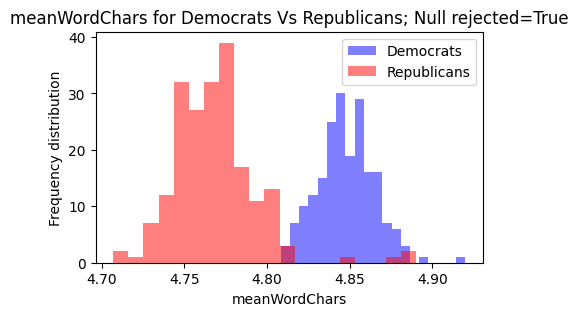

In [ ]:
# If you want to see the difference between democrats and republicans on the meanWordChars metric
plot_distributions (sample_dem_metrics, 
                    sample_rep_metrics, 
                    group1_name="Democrats", 
                    group2_name="Republicans", 
                    metric="meanWordChars")

Empirical CI for Democrats: (0.0680089485458613, 0.07499139242755756)
Empirical CI for Republicans: (0.0659020234599864, 0.07497153380097558)
Fail to reject the null hypothesis


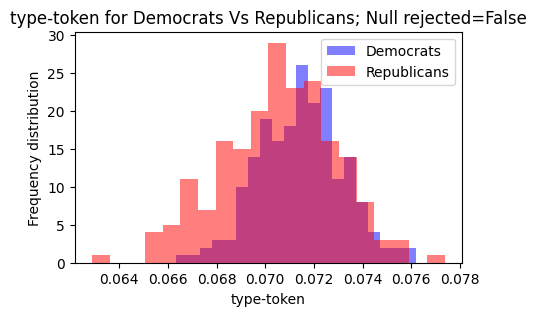

In [ ]:
# If you want to see the difference between the democrats and republicans on the type-token ratio metric
plot_distributions (sample_dem_metrics, 
                    sample_rep_metrics, 
                    group1_name="Democrats", 
                    group2_name="Republicans", 
                    metric="type-token")

Empirical CI for Congressmen: (4.749508627047117, 4.828385980968788)
Empirical CI for Congresswomen: (4.878087047856627, 4.939137271141969)
Reject the null hypothesis


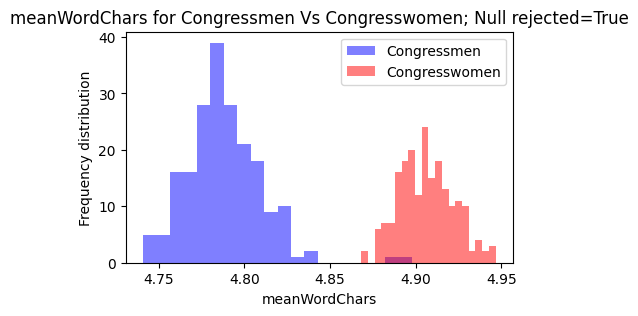

In [ ]:
plot_distributions (sample_men_metrics, 
                    sample_women_metrics, 
                    group1_name="Congressmen", 
                    group2_name="Congresswomen", 
                    metric="meanWordChars")

Empirical CI for Congress107: (4.759330636794621, 4.838334473658489)
Empirical CI for Congress111: (4.7851088636780466, 4.873722311528644)
Fail to reject the null hypothesis


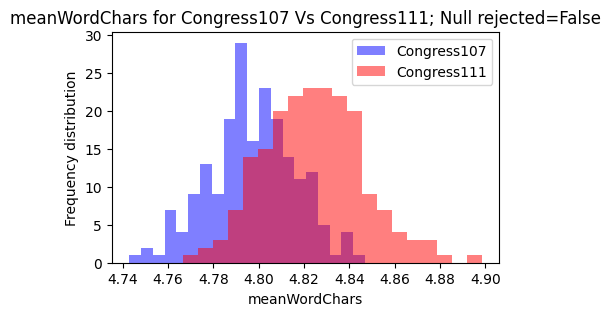

In [ ]:
plot_distributions (sample_cong107_metrics, 
                    sample_cong111_metrics, 
                    group1_name="Congress107", 
                    group2_name="Congress111", 
                    metric="meanWordChars")

# 3. Lexical Variation

Implement the following functions to get exlusive words in one vocabulary with respect to another and calculate the PMI of each word given the entire corpus.

In [ ]:
def set_exclusive (vocab1, vocab2):
  """ Function calculates the set of words that are exclusive to the first
  vocabulary when compared to the second vocabulary i.e. words that are in the
  first vocabulary but not in the second vocabulary.

  params
  :vocab1: dict; keys are the word types and values are the number of times they
          appear in the first corpus
  :vocab2: dict; keys are the word types and values are the number of times they
          appear in the second corpus

  returns
  :exclusive: set
  """
  exclusive = set ()
  # found =0 
  # Write your code below  
  #for word1 in vocab1.keys():
  #      for word2 in vocab2.keys():
  #          if word1 == word2:
  #             found =1;
  #             break;
  #      if found == 0:
  #          exclusive.append(word1);
  exclusive = set(vocab1.keys()) - set(vocab2.keys()) 
  return exclusive

You can now calculate the length of the set of exclusive words in one set over another. Implement the following function, in addition, which will take a set of exclusive words in a vocabulary and sort them based on their frequency/counts in the corpus.

In [ ]:
def sort_exclusive (exclusive, vocab, k=10):
  """ Function returns the most frequent items within the exclusive words.

  params
  :exclusive: set
  :vocab: dict; keys are the word types and values are the number of times they
          appear in the corpus
  :k: int (default: 10); number of items to return

  returns
  :top_k: list of tuples (word, count)
  """
  top_k = list ()
  # Write your code below
  exclusive_vocab = {word: vocab[word] for word in exclusive}
  sorted_exclusive_vocab = sorted(exclusive_vocab.items(), key=lambda x: x[1], reverse=True)
  top_k = sorted_exclusive_vocab[:k]
    
  return top_k

A more principled approach for identifying words that are under or over-represented in one corpus compared to another is by calculating the pointwise mutual information (PMI) for each word with respect to individual corpora and then taking the difference between the two as a proxy measure of under or over representation.

In general, PMI (X,Y) for two events can be calculated as:

$$ PMI (X,Y) = \log_2\left(\frac{Pr (X,Y)}{Pr(X)\cdot Pr(Y)}\right)$$

Rewriting this further,
$$ PMI (X,Y) = \log_2\left(\frac{Pr (X|Y) \cdot Pr (Y)}{Pr(X)\cdot Pr(Y)}\right)$$
$$  = \log_2\left(\frac{Pr (X|Y)}{Pr(X)}\right)$$

We're interested in finding the PMI of any word, say, _vote_ with respect to a specific group, say, republicans. In this case, our two events are:

1. X=speech contains the word _vote_
2. Y=speech is made by a republican.

In this case, $Pr(\text{speech contains vote} | \text{speech is made by republican})$ can be calculated from the vocabulary constructed by slicing the corpus into a republican group. On the other hand, $Pr(\text{speech contains vote})$ needs to be calculated by considering the vocabulary from the entire corpus (i.e. without any slicing).

Note though that we're going to calculate the PMI with respect to two groups and take their difference. If you expand the log function in the PMI calculation and take PMI differences, you'll find that the denominator term cancels out. You can do this math yourself to verify.

Thus,

$$ PMI (X=vote,Y=republican) - PMI (X=vote,Y=democrat) = \log_2\left({Pr (X=vote|Y=republican) }\right) - \log_2\left({Pr (X=vote|Y=democrat) }\right)$$

One problem you'll face is that for words that are used in one vocabulary and not the other, the probabilities are going to be zero and the log will be undefined. To avoid this problem, you can assume a small non-zero count is added to every word in the vocabularies. This process is called smoothing.

Without smoothing, you can calculate the probability of a word, say, _vote_ as:

$$ Pr(vote) = \frac{\# vote}{\# \text{any word}} = \frac{Count(vote)}{N}$$,

where $N$ is the number of tokens in the corpus and $Count(\cdot)$ is a function that return the number of times the input word to the function appears in the corpus.

With smoothing, you can calculate the same probability as:

$$ Pr(vote) = \frac{Count(vote) + \alpha}{N+|V|\cdot \alpha}$$

where $\alpha$ can be any real number but is typically taken to be an integer. Now, let's write a function that will give the probability after smoothing.

In [ ]:
def smooth_prob (vocab, word, N, alpha=1):
  """ Function calculates the smoothed probability of a word in a vocabulary.

  The logic of this function should be that if word is present in the vocab,
  return the probability of the word assuming it occurs vocab[word] + alpha
  times in the corpus. If word is not present in the vocab, calculate the
  probability as if it occurs alpha times.

  params
  :vocab: dict; keys are the word types and values are the number of times they
          appear in the corpus
  :word: str
  :N: int; number of tokens in the corpus

  :alpha: float (default: 1); smoothing constant

  returns
  :prob: float
  """
  prob = 0.0
  # Write your code below
  if word in vocab.keys():
      prob = (vocab[word]+alpha)/(N+len(vocab)*alpha)
  else:
      prob = alpha/(N+len(vocab)*alpha)

  return prob

Make use of the `smooth_prob` function to calculate the PMI for any list of words

In [ ]:
def pmi_diff(words, vocab1, vocab2):
  """ Function calculates the PMI difference for each word in the list of words.

  params
  :words: list of words
  :vocab1: dict; keys are the word types and values are the number of times they
          appear in the first corpus
  :vocab2: dict; keys are the word types and values are the number of times they
          appear in the second corpus

  returns
  pmi_words: list of tuples (word, pmi)
  """

  pmi_words = list()
  N1= sum(vocab1.values());
  N2= sum(vocab2.values());
  # Write your code below
  for word in words:
      prob1 =  smooth_prob(vocab1, word, N1, alpha=1);
      prob2 =  smooth_prob(vocab2, word, N2, alpha=1);
      pmi = math.log2(prob1)-math.log2(prob2);
      pmi_words.append((word, pmi));

  return pmi_words

Once you have the PMI difference for each word, you can rank each word based on this difference. Depending on the sign and the rank of the word, you'll be able to deduce words that are over or underrepresented in one group over another.

Now put everything together to answer the following questions

#### **2a** Exclusive and overrepresented words by republicans over democrats; and vice versa.

In [ ]:
# Write your code below
exclusive_dem=set_exclusive (dem_vocab, rep_vocab);
print("exclusive words by democrats over republicans:", sort_exclusive (exclusive_dem, dem_vocab, k=10));
exclusive_rep=set_exclusive (rep_vocab, dem_vocab);
print("exclusive words by republicans over democrats:", sort_exclusive (exclusive_rep, rep_vocab, k=10));
#pmi_dem=pmi_diff(dem_vocab.keys(),dem_vocab, rep_vocab);
pmi_dem=pmi_diff(dem_vocab.keys(),dem_vocab, rep_vocab);
pmi_dem_sorted = sorted(pmi_dem, key=lambda x: x[1], reverse=True);

exclusive words by democrats over republicans: [('sonoma', 141), ('drinan', 123), ('apa', 98), ('accutane', 74), ('lgbt', 72), ('30somethings', 69), ('kalaupapa', 67), ('bluedog@mail.house.gov.', 62), ('$618', 61), ('unbid', 59)]
exclusive words by republicans over democrats: [('obamacare.', 220), ('entity:', 181), ('hubbert', 121), ('compean.', 111), ('pantano', 110), ('hubberts', 109), ('bow:', 93), ('...............................................', 74), ('..............................................', 69), ('eximbank', 59)]


In [ ]:
print("Top 30 words by PMI difference (favoring Democrats):")
for word, pmi in pmi_dem_sorted[10:40]:
    print(f"{word}: {pmi:.4f}")

Top 30 words by PMI difference (favoring Democrats):
mosk: 5.6485
30somethingdems@mail.house.gov.: 5.5979
halliburtons: 5.4910
3619: 5.4910
antichoice: 5.4630
boccieri.: 5.4344
cbc: 5.4126
cnmi: 5.3451
roybal: 5.2931
$26.625: 5.2824
drinan.: 5.2824
lwcf: 5.1829
capac.: 5.1829
accutane.: 5.1829
snohomish: 5.1481
plame: 5.1125
kalaupapa.: 5.1125
cardholder: 5.0760
apia: 5.0760
2010".: 5.0760
chamorro: 5.0636
housedemocrats.gov.: 5.0385
tonko.: 5.0258
laborhealtheducation: 4.9605
albinism: 4.9605
rodino: 4.9504
uxo: 4.9198
30something.: 4.8780
miss..: 4.8780
340b: 4.8780


#### **2b** Exclusive and overrepresented words by congresswomen over congressmen; and vice versa.

In [ ]:
# Write your code below


#### **2c** Exclusive and overrepresented words in 107th congress over 111th congress; and vice versa

In [ ]:
# Write your code below


#### **2d** Exclusive and overrepresented words in US congress over UK parliament; and vice versa

# 4. Semantic variation

Implement the following functions to check for semantic variation between any two groups.

Given two word2vec models, let's first write a function to quantify the differences between the two models for a specific word. We'll implement Eq.2 from [this paper](https://aclanthology.org/2020.acl-main.51.pdf).

**Hint**: You'll use the `wv.most_similar` most method to get the near neighbors.

In [ ]:
def semantic_variation (model1, model2, word, k=100):
  """ Function scores the semantic variation between two word2vec models for a
  specific word using the near neighbors of the word in both the models.

  params
  :model1: gensim.models.keyedvectors.Word2VecKeyedVectors
  :model2: gensim.models.keyedvectors.Word2VecKeyedVectors
  :word: str
  :k: int (default: 100); number of neighbors to consider

  returns
  :score: float
  """

  score = 0
  # Write your code below
    
  return score

Next, you'll write a function that can compare two models on any set of words and rank them based on the semantic variation score.

In [ ]:
def rank_words_on_semantic_variation (model1, model2, words, thresh=0, k=100):
    """ Function ranks words based on the semantic variation score. 
        Words whose semantic score falls below the threshold are ignored.

        params
        :model1: gensim.models.keyedvectors.Word2VecKeyedVectors
        :model2: gensim.models.keyedvectors.Word2VecKeyedVectors
        :words: list
        :thresh: float (default: 0); threshold below which words are ignored
        :k: int (default: 100); number of neighbors to consider

        returns
        :ranked_words: list; each item in the item is a tuple of 
                       two things - word and its semantic variation score;
                       list is sorted according from highest semantic 
                       variation to lowest
    """
    ranked_words = list ()
    # Write your code below

    return ranked_words

Broadly speaking, we have two options for training a word2vec model

1. We train a new word2vec model on a corpus. This means that the embeddings are initialized randomly and then iteratively updated.
2. We take a pretrained word2vec model and then update the embeddings by _finetuning_ them on the corpus.

We'll use the finetuning approach here because it has one distinct advantage. Since we don't update the embeddings from a random point, our embeddings are likely to be of high quality.

The following function continues to train the model with additional sentences in a corpus.

In [ ]:
def finetune_model (pretrained_model, corpus, epochs=3):
  """ Function creates a new model by initializing the vectors of the model
  with the vectors passed in the pretrained_model.

  params
  :pretrained_model: gensim.models.keyedvectors.Word2VecKeyedVectors
  :corpus: list of lists of strings
  :epochs: int (default: 3); number of epochs to finetune.

  returns
  :new_model: gensim.models.keyedvectors.Word2VecKeyedVectors
  """

  # Initialize a new Word2Vec model with the same parameters as the pre-trained model
  new_model = Word2Vec(
    vector_size=pretrained_model.vector_size,  # Same dimensions as the pretrained embeddings
    window=5,                                      # Size of the window for context words
    min_count=1,                                   # Minimum count for words to be considered
    workers=4                                      # Number of threads to use
  )

  # Build the vocabulary using the new training corpus
  new_model.build_vocab(corpus)

  # Initialize the new model's embeddings with the pre-trained embeddings
  # Only for the words present in both vocabularies
  for word in new_model.wv.key_to_index:
    if word in pretrained_model.key_to_index:
      new_model.wv[word] = pretrained_model[word]

  # Train the new model for a fixed number of epochs
  new_model.train(
    corpus,
    total_examples=new_model.corpus_count,
    epochs=epochs  # Adjust the number of epochs as needed
  )

  return new_model

One can now finetune an existing model on any corpus. Suppose our corpus just contained one document, whose contained was the sentence "hello world", then we can update the embeddings by passing this training corpus and the pretrained model to the `finetune_model` function as follows.

In [ ]:
# Here's how use the above function
training_corpus = [
    ['hello', 'world']
]
new_model = finetune_model (w2v_pretrained_model, training_corpus)

You'll now finetune the pretrained models on slices of the data. For example, to answer 3a, you'll finetune a model on 25000 random speeches from the democrat set of speeches and finetune another model on 25000 random speeches from the republican set.



**Notes** 

- Finetuning two models on approximately 25000 speeches takes me about 5-7 minutes so don't worry if you feel your model training is taking too long; on the other hand, if finetuning is taking over an hour, then reach out to me.
- Make sure the corpus is formatted as a list of list of tokens. Any other format and gensim will throw an error.
- You can use the `random` module to sample 25000 speeches.

#### 3a Republican Vs Democrats

In [ ]:
import random

# Write your code below (construct the two corpora)
pass

# Write your code below (finetune the pretrained model on each corpus separately)
pass

# Write your code below (compare the two finetuned models on all common words in both model vocabularies
pass

#### 3b Congressman Vs Congresswoman

In [ ]:
import random

# Write your code below (construct the two corpora)
pass

# Write your code below (finetune the pretrained model on each corpus separately)
pass

# Write your code below (compare the two finetuned models on all common words in both model vocabularies
pass

#### 3c 107th Congress Vs 111th Congress

In [ ]:
import random

# Write your code below (construct the two corpora)
pass

# Write your code below (finetune the pretrained model on each corpus separately)
pass

# Write your code below (compare the two finetuned models on all common words in both model vocabularies
pass

#### 3d US Vs UK

In [ ]:
import random

# Write your code below (construct the two corpora)
pass

# Write your code below (finetune the pretrained model on each corpus separately)
pass

# Write your code below (compare the two finetuned models on all common words in both model vocabularies
pass

#### 4a and 4b

In [ ]:
interesting_words = {
    "immigration": ["immigration", "asylum", "border"],
    "healthcare": ["health", "insurance", "obamacare"],
    "gun_reform": ["gun", "safety", "rights"],
    "lgbtq": ["gay", "rights", "marriage"],
    "abortion": ["abortion", "choice", "parenthood"]
}

for issue in interesting_words:
  for word in interesting_words[issue]:
    # Write your code below (calculate the semantic variation for each word)
    pass